In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_203.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_400x_471.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_400x_398.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_196.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_400x_135.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_266.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_408.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_435.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_156.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_100x_346.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_400x_353.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC_400x_481.jpg
/kaggle/input/datasets/ashenafifasilkebede/dataset/val/OSCC/OSCC

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# ------------------------
# Config
# ------------------------
DATA_DIR = "/kaggle/input/datasets/zaidpy/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new"
BATCH_SIZE = 16
EPOCHS = 20
LR = 1e-4
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [4]:
# ------------------------
# Reproducibility
# ------------------------
torch.manual_seed(42)
np.random.seed(42)

# ------------------------
# Transforms
# ------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
# ------------------------
# Class Weights
# ------------------------
targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(targets),
    y=targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)


NameError: name 'train_dataset' is not defined

In [17]:
import torch.nn.functional as F
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset

In [7]:
# Load dataset without transform first
full_dataset = datasets.ImageFolder(DATA_DIR)

class_names = full_dataset.classes
targets = full_dataset.targets
targets = np.array(targets)

In [8]:
# First split: Train (70%) and Temp (30%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.30,
    stratify=targets,
    random_state=42
)

# Second split: Temp -> Val (15%) & Test (15%)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,
    stratify=targets[temp_idx],
    random_state=42
)

print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

Train size: 665
Val size: 142
Test size: 143


In [9]:
# Create separate dataset objects
train_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=train_transform),
    train_idx
)

val_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=val_transform),
    val_idx
)

test_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=val_transform),
    test_idx
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_targets = targets[train_idx]

fold_results = []

In [11]:
best_fold_f1 = 0.0
best_model_path = "/kaggle/working/best_cv_model.pkl"

for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(train_idx, train_targets)):

    print(f"\n========== Fold {fold+1} ==========")

    # Create datasets (same as before)
    fold_train_idx = np.array(train_idx)[train_fold_idx]
    fold_val_idx = np.array(train_idx)[val_fold_idx]

    fold_train_dataset = Subset(
        datasets.ImageFolder(DATA_DIR, transform=train_transform),
        fold_train_idx
    )

    fold_val_dataset = Subset(
        datasets.ImageFolder(DATA_DIR, transform=val_transform),
        fold_val_idx
    )

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # New model per fold
    model = models.densenet169(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # Train
    for epoch in range(5):
        model.train()
        for images, labels in fold_train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in fold_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    fold_f1 = f1_score(y_true, y_pred)
    print(f"Fold {fold+1} F1: {fold_f1:.4f}")

    # Save best fold model
    if fold_f1 > best_fold_f1:
        best_fold_f1 = fold_f1

        torch.save({
            "model_state_dict": model.state_dict(),
            "class_names": class_names,
            "img_size": IMG_SIZE
        }, best_model_path)

        print(f"Saved best fold model at {best_model_path}")


========== Fold 1 ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 165MB/s] 
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 1 F1: 0.9023
Saved best fold model at /kaggle/working/best_cv_model.pkl

========== Fold 2 ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 2 F1: 0.9545
Saved best fold model at /kaggle/working/best_cv_model.pkl

========== Fold 3 ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 3 F1: 0.9173

========== Fold 4 ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 4 F1: 0.9268

========== Fold 5 ==========


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 5 F1: 0.9600
Saved best fold model at /kaggle/working/best_cv_model.pkl


In [15]:
SAVE_PATH = "/kaggle/working/best_cv_model.pkl"



=== Test set results ===
Test Accuracy: 0.9441
Test Precision: 0.9412
Test Recall: 0.9412
Test F1-score: 0.9412
Confusion Matrix:
 [[71  4]
 [ 4 64]]
Classification Report:
               precision    recall  f1-score   support

      CANCER       0.95      0.95      0.95        75
  NON CANCER       0.94      0.94      0.94        68

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143

Test AUC: 0.9857


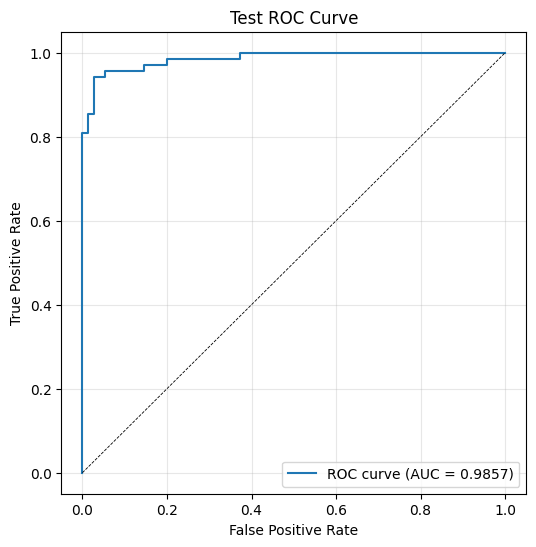


Final model file saved at: /kaggle/working/best_cv_model.pkl


In [18]:
# ------------------------
# Load best model and evaluate on TEST set only
# ------------------------
checkpoint = torch.load(SAVE_PATH, map_location=DEVICE)
model_best = models.densenet169(pretrained=False)
model_best.classifier = nn.Linear(model_best.classifier.in_features, len(class_names))
model_best.load_state_dict(checkpoint["model_state_dict"])
model_best = model_best.to(DEVICE)
model_best.eval()

# Collect test predictions and probabilities
y_true_test, y_pred_test, y_prob_test = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_best(images)                     # (N, C)
        probs = F.softmax(outputs, dim=1)               # (N, C)
        preds = torch.argmax(outputs, dim=1)

        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())
        # take positive class prob (assume class index 1 is 'CANCER' or adjust accordingly)
        if probs.shape[1] == 2:
            y_prob_test.extend(probs[:, 1].cpu().numpy())
        else:
            # for multiclass you might want one-vs-rest AUC per class
            y_prob_test.extend(probs.cpu().numpy())

# Metrics
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
print("\n=== Test set results ===")
acc_test = accuracy_score(y_true_test, y_pred_test)
prec_test = precision_score(y_true_test, y_pred_test, average='binary' if len(class_names)==2 else 'macro', zero_division=0)
rec_test = recall_score(y_true_test, y_pred_test, average='binary' if len(class_names)==2 else 'macro', zero_division=0)
f1_test = f1_score(y_true_test, y_pred_test, average='binary' if len(class_names)==2 else 'macro', zero_division=0)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test Precision: {prec_test:.4f}")
print(f"Test Recall: {rec_test:.4f}")
print(f"Test F1-score: {f1_test:.4f}")

cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))

# ROC & AUC for binary
if len(class_names) == 2:
    y_prob_test = np.array(y_prob_test)
    fpr, tpr, thresholds = roc_curve(y_true_test, y_prob_test)
    roc_auc = auc(fpr, tpr)
    print(f"Test AUC: {roc_auc:.4f}")

    # Plot ROC curve (optional)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], 'k--', linewidth=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

print(f"\nFinal model file saved at: {SAVE_PATH}")

TEST WITH EXTERNAL IMAGES

In [ ]:
model = models.densenet169(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, 2)

model.load_state_dict(torch.load("/kaggle/working/best_cv_model.pkl", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()


In [ ]:
def predict_image(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = eval_transform(image).unsqueeze(0).to(DEVICE)

    # Inference
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    pred_idx = np.argmax(probs)
    pred_class = CLASS_NAMES[pred_idx]
    confidence = probs[pred_idx]

    return pred_class, confidence, probs


In [ ]:
image_path = "/kaggle/input/datasets/ashenafifasilkebede/dataset/test/Normal/Normal_100x_12.jpg"  # change path

pred_class, confidence, probs = predict_image(image_path)

print("Prediction:", pred_class)
print("Confidence:", round(confidence * 100, 2), "%")
print("Probabilities:", probs)
